<a href="https://colab.research.google.com/github/nthanhkhang/Vietnamese-Social-Media-Emotion-Corpus/blob/main/Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Sentiment-Analysis-with-Attention**

A model to perform sentiment analysis on wikipedia comments using attention mechanism in keras.

Data from UIT-VSMEC.zip classification challenge.

The word embeddings can be downloaded from [here](https://github.com/nthanhkhang/Natural-Language-Processing/raw/main/Data/UIT-VSMEC.zip).


# I.Import Library





## 1.Download Packet

In [1]:
%tensorflow_version 1.x
!pip install keras==2.2.5
!pip install pyvi

TensorFlow 1.x selected.


In [2]:
import numpy as np
from numpy import random
import os, pickle, re, keras, sklearn, string
from keras.callbacks import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from pyvi import ViTokenizer, ViPosTagger
from keras.layers import *
from keras.models import Model
from keras import optimizers
import gensim, operator, json
import pandas as pd
from sklearn.metrics import *
import keras.backend as K
from keras.models import *
from keras import initializers, regularizers
from keras import optimizers
from keras.engine.topology import Layer
from keras import constraints

Using TensorFlow backend.


## 2.Download Word2Vec model 

In [3]:
import os

%cd /content
if not os.path.exists("baomoi.model.bin"):
  !wget -P /content/ -c "https://thiaisotajppub.s3-ap-northeast-1.amazonaws.com/publicfiles/baomoi.model.bin"
else:
  print("word2vec already downloaded")

/content
word2vec already downloaded


## 3.Download Data

In [4]:
%cd /content
if not os.path.exists("UIT-VSMEC.zip"):
  !wget -P /content/ -c "https://github.com/nthanhkhang/Natural-Language-Processing/raw/main/Data/UIT-VSMEC.zip"
else:
  print("UIT-VSMEC.zip already downloaded")

/content
UIT-VSMEC.zip already downloaded


# II.Read Data

In [14]:
import zipfile
with zipfile.ZipFile("UIT-VSMEC.zip","r") as zf:
    zf.extractall('')
print(zf)

<zipfile.ZipFile [closed]>


In [15]:
path_train ='data/train_nor_811.csv'
path_valid ='data/valid_nor_811.csv'
path_test ='data/test_nor_811.csv'
path_stopword = 'data/stopwords.txt'

# III.Word2vec using baomoi.model.bin

*   Function reading pretrain word embedding library.
*   The word embedding pretrain has been trained in new news, 300-way news



In [16]:
path_embedding= 'baomoi.model.bin'

import io
from gensim.models import KeyedVectors

word_embedding = KeyedVectors.load_word2vec_format(path_embedding, binary=True)
# Example of taking vector of 1 word in the word embedding pretrain
EMBEDDING_DIM = word_embedding['yêu'].shape[0]
print("Embedding: ",EMBEDDING_DIM)
# Vector of love words in pretrained word embedding set.
print(word_embedding['yêu'])


Embedding:  400
[-0.78774583 -0.22327825 -0.6274532  -2.7228408  -2.2186291   0.38002455
  3.8660462   0.9853684  -1.4683082  -1.7013292  -0.5839958  -0.14467287
  3.600142    3.381808   -0.02930526  3.0047843  -0.2006207  -1.0937127
  1.7360235   2.3691583  -0.71597415  3.319453    0.2824182  -3.0814204
  2.6810844  -0.810977    1.5186927  -2.10329     1.3271075  -1.3646411
 -0.11144319 -4.6505136  -1.7251624  -2.31126     1.583203   -0.8746506
 -2.6937015  -1.7733976   0.557898   -1.7562917   1.3282276  -0.3805479
 -1.3979301  -0.1536707  -1.1909302   1.3283668   0.22275637 -2.7959821
 -5.188217   -0.6404673   0.0164395   0.67177856 -1.4948794   0.21867418
 -1.4103376   0.99262404  2.2180524  -0.4881204   3.0988753  -0.31382522
  1.3226501   0.21269594 -1.6409203   1.7758838   2.3379912  -2.4666297
 -0.599687    0.551105   -1.3755493  -1.4293027  -2.6366289   0.40759587
 -0.77850854 -0.6169452  -0.84525913  0.02801617  2.1296268   0.13715844
 -1.1562283  -2.1226277  -0.1346792   0.88

# IV. Data Preprocessing

## 1.Tokenizer

In [17]:
def tokenizer(text):
    token = ViTokenizer.tokenize(text)
    return token

## 2.Delete Icon

In [18]:
def deleteIcon(text):
    text = text.lower()
    s = ''
    pattern = r"[a-zA-ZaăâbcdđeêghiklmnoôơpqrstuưvxyàằầbcdđèềghìklmnòồờpqrstùừvxỳáắấbcdđéếghíklmnóốớpqrstúứvxýảẳẩbcdđẻểghỉklmnỏổởpqrstủửvxỷạặậbcdđẹệghịklmnọộợpqrstụựvxỵãẵẫbcdđẽễghĩklmnõỗỡpqrstũữvxỹAĂÂBCDĐEÊGHIKLMNOÔƠPQRSTUƯVXYÀẰẦBCDĐÈỀGHÌKLMNÒỒỜPQRSTÙỪVXỲÁẮẤBCDĐÉẾGHÍKLMNÓỐỚPQRSTÚỨVXÝẠẶẬBCDĐẸỆGHỊKLMNỌỘỢPQRSTỤỰVXỴẢẲẨBCDĐẺỂGHỈKLMNỎỔỞPQRSTỦỬVXỶÃẴẪBCDĐẼỄGHĨKLMNÕỖỠPQRSTŨỮVXỸ,._]"
    for char in text:
        if char !=' ':
            if len(re.findall(pattern, char)) != 0:
                s+=char
            elif char == '_':
                s+=char
        else:
            s+=char
    s = re.sub('\\s+',' ',s)
    return s.strip()

## 3.Clean Doc

In [19]:
def clean_doc(doc):
    doc = tokenizer(doc)
    for punc in string.punctuation:# delete all punctuation (!,? ..) in a sentence
        if punc != "_":
            doc = doc.replace(punc,' ')
    doc = deleteIcon(doc) 
    doc = re.sub(r"[0-9]+", " num ", doc)# Delete numbers
    doc = doc.lower()#lowercase 
    doc = re.sub('\\s+',' ',doc)# Remove lots of spaces
    return doc

## 4.Stopword

In [20]:
# from underthesea import word_tokenize
def pre_process(questions):
    stop_words = stopwords.words("english")
    questions_stop = [[t for t in tokens if (t not in stop_words) and (3 < len(t.strip()) < 15)]
                      for tokens in questions_tokens]
    questions_stop = pd.Series(questions_stop)
    return questions_stop

## 5.Word Segmentation

In [21]:
def word_tokenize(text):
    token = word_tokenize.tokenize(text)
    return token

# V.Train/Test data

In [23]:
train_data = pd.read_csv(path_train,encoding='utf-8')
valid_data = pd.read_csv(path_valid,encoding='utf-8')
test_data = pd.read_csv(path_test,encoding='utf-8')

X_train = train_data["Sentence"].apply(lambda x : clean_doc(x))
y_train = train_data["Emotion"]

X_val = valid_data["Sentence"].apply(lambda x : clean_doc(x))
y_val = valid_data["Emotion"]

X_test = test_data["Sentence"].apply(lambda x : clean_doc(x))
y_test = test_data["Emotion"]

In [24]:
print(len(X_train),len(y_train))
print(len(X_val),len(y_val))
print(len(X_test),len(y_test))


5548 5548
686 686
693 693


## DataFrame link1.csv

In [25]:
df = pd.DataFrame(X_train)
df.columns = ["Sentence"]
df['Emotion']=df['Sentence'].apply(len)
df['Emotion'] = pd.DataFrame(y_train)
df.head()

,Sentence,Emotion
0,cho mình xin bài nhạc tên là gì với ạ,Other
1,cho đáng_đời con quỷ về nhà lôi con nhà mày ra...,Disgust
2,lo học đi yêu_đương lol gì hay lại thích học_s...,Disgust
3,uớc gì sau_này về già vẫn có_thể như cụ này,Enjoyment
4,mỗi lần có video của con là cứ coi đi coi lại ...,Enjoyment


## DataFrame link2.csv

In [26]:
df = pd.DataFrame(X_val)
df.columns = ["Sentence"]
df['Emotion']=df['Sentence'].apply(len)
df['Emotion'] = pd.DataFrame(y_val)
df.head()

,Sentence,Emotion
0,tính tao tao biết chẳng có chuyện gì có_thể là...,Other
1,lại là lào cai tự_hào quê mình quá,Enjoyment
2,bị từ_chối rồi,Sadness
3,tam_đảo trời đẹp các mem à,Enjoyment
4,đọc bình_luận của thằng đó không thiếu chữ nào,Other


## DataFrame link3.csv

In [27]:
df = pd.DataFrame(X_test)
df.columns = ["Sentence"]
df['Emotion']=df['Sentence'].apply(len)
df['Emotion'] = pd.DataFrame(y_test)
df.head()

,Sentence,Emotion
0,người_ta có bạn_bè nhìn vui thật,Sadness
1,cho nghỉ viêc mói đúng sao goi là kỷ_luật,Surprise
2,kinh vãi,Disgust
3,nhà thì không xa lắm nhưng chưa bao_giờ đi vì ...,Fear
4,bố không thích nộp đấy mày thích ý_kiến không,Anger


maximum Sentence sequence length >> 230


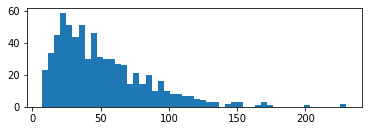

In [30]:
import matplotlib.pyplot as plt

Sentence_lengths = [len(s) for s in X_test]
print(f"maximum Sentence sequence length >> {np.max(Sentence_lengths)}")
plt.subplot(2,1,1)
plt.hist(Sentence_lengths,bins=50)
plt.show()

## 1.Catalog vector

In [31]:
classes = ['Anger','Disgust','Enjoyment','Fear','Other','Sadness','Surprise']
def to_category_vector(label):
    vector = np.zeros(len(classes)).astype(np.float64)
    index = classes.index(label)
    vector[index] = 1.0
    return vector

## 2.Convert labels to numbers in train and test practice

In [32]:
y_train_encode = []
for label in y_train:
    y_train_encode.append(to_category_vector(label))


y_val_encode = []
for label in y_val:
    y_val_encode.append(to_category_vector(label))

print(classes)
print(y_train_encode[0])
print(y_train[0])

['Anger', 'Disgust', 'Enjoyment', 'Fear', 'Other', 'Sadness', 'Surprise']
[0. 0. 0. 0. 1. 0. 0.]
Other


## 3.LSTM


*   All the words in the X_train set will form a dictionary
*   Each vector of the input word, it will turn into a vector with a fixed number of dimensions and each vocabulary will be replaced by its index in the dictionary
* Number of vector dimensions per input we will take the longest sentence which is the direction of the vector and the shorter arcs will automatically add the value 0 after

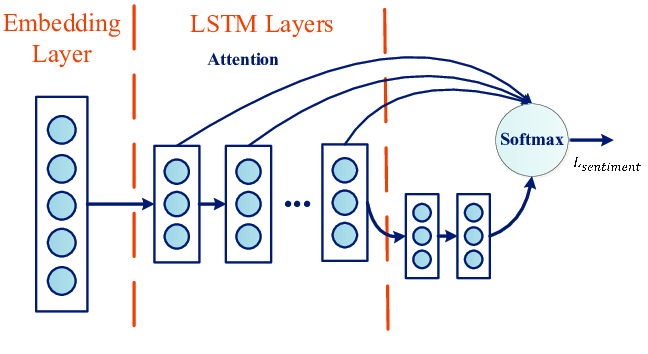

In [33]:
xLengths = [len(x.split(' ')) for x in X_train]
h = sorted(xLengths)  #sorted lengths
maxLength =h[len(h)-1]
print("The longest sentence length value: ",maxLength)
input_tokenizer = Tokenizer(filters="",oov_token="UNK")
input_tokenizer.fit_on_texts(X_train)
input_vocab_size = len(input_tokenizer.word_index) + 1
word_index = input_tokenizer.word_index
print("input_vocab_size:",input_vocab_size)
X_train_encode = np.array(pad_sequences(input_tokenizer.texts_to_sequences(X_train), maxlen=maxLength,padding="post"))

The longest sentence length value:  134
input_vocab_size: 6135


## 4.Enter the example using LSTM

In [34]:
print("Input String : ", X_train[0])
print("Encode : ",X_train_encode[0])
X_val_encode = np.array(pad_sequences(input_tokenizer.texts_to_sequences(X_val), maxlen=maxLength,padding="post"))

Input String :  cho mình xin bài nhạc tên là gì với ạ
Encode :  [ 13  23 292 166 417 372   4  17  47 182   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0]


## 5.Generate Embedding
Function takes the vector of vocabulary in pre-trained word embedding

In [35]:
def generate_embedding(word_index, model_embedding,EMBEDDING_DIM):
    count6 = 0
    countNot6 = 0
    #embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM)) 
    embedding_matrix = np.asarray([np.random.uniform(-0.01,0.01,EMBEDDING_DIM) for _ in range((len(word_index) + 1))])
    list_oov = []
    word_is_trained = []
    for word, i in word_index.items():
        try:
            embedding_vector = model_embedding[word]
            word_is_trained.append(word)
        except:
            continue
        if embedding_vector is not None:
            count6 +=1
            embedding_matrix[i] = embedding_vector
    
    print('Number of words in pre-train embedding: ' + str(count6))
    print('Number of words not in pre-train embedding: ' + str(countNot6))
    return embedding_matrix,word_is_trained

In [36]:
embedding_matrix,word_is_trained = generate_embedding(word_index,word_embedding,EMBEDDING_DIM)
print(word_is_trained)

Number of words in pre-train embedding: 5647
Number of words not in pre-train embedding: 0
['không', 'tao', 'là', 'có', 'mà', 'này', 'nó', 'đi', 'thì', 'rồi', 'cái', 'cho', 'per', 'được', 'cũng', 'gì', 'con', 'quá', 'người', 'lại', 'như', 'mình', 'làm', 'còn', 'của', 'mày', 'ra', 'thấy', 'phải', 'mấy', 'vãi', 'thôi', 'em', 'nào', 'và', 'đó', 'anh', 'để', 'luôn', 'đã', 'thế', 'chứ', 'nhìn', 'đéo', 'hay', 'với', 'bạn', 'biết', 'bị', 'sao', 'nhưng', 'cả', 'thằng', 'chỉ', 'thật', 'đâu', 'xem', 'ai', 'mới', 'nhà', 'nữa', 'vậy', 'khi', 'mẹ', 'nói', 'vào', 'lắm', 'ăn', 'lên', 'sợ', 'về', 'vẫn', 'đến', 'một', 'chưa', 'nhiều', 'lần', 'hết', 'ở', 'hơn', 'yêu', 'năm', 'sẽ', 'ngày', 'tôi', 'muốn', 'đấy', 'nên', 'các', 'xong', 'phim', 'trong', 'cười', 'đây', 'những', 'vì', 'cứ', 'đúng', 'đứa', 'nhỉ', 'ông', 'thích', 'giờ', 'lúc', 'mặt', 'nhau', 'ấy', 'nhớ', 'à', 'tiền', 'đáng', 'nhất', 'chắc', 'gặp', 'đang', 'nhé', 'từ', 'học', 'bọn', 'mất', 'đừng', 'nghe', 'chó', 'chết', 'rất', 'khác', 'bố', 'buồn

# VI.Attention Layer

In [37]:
def dot_product(x, kernel):
	if K.backend() == 'tensorflow':
		return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
	else:
		return K.dot(x, kernel)

class AttentionWithContext(Layer):
	def __init__(self,
				 W_regularizer=None, u_regularizer=None, b_regularizer=None,
				 W_constraint=None, u_constraint=None, b_constraint=None,
				 bias=True, **kwargs):

		self.supports_masking = True
		self.init = initializers.get('glorot_uniform')

		self.W_regularizer = regularizers.get(W_regularizer)
		self.u_regularizer = regularizers.get(u_regularizer)
		self.b_regularizer = regularizers.get(b_regularizer)

		self.W_constraint = constraints.get(W_constraint)
		self.u_constraint = constraints.get(u_constraint)
		self.b_constraint = constraints.get(b_constraint)

		self.bias = bias
		super(AttentionWithContext, self).__init__(**kwargs)

	def build(self, input_shape):
		assert len(input_shape) == 3

		self.W = self.add_weight((input_shape[-1], input_shape[-1],),
								 initializer=self.init,
								 name='{}_W'.format(self.name),
								 regularizer=self.W_regularizer,
								 constraint=self.W_constraint)
		if self.bias:
			self.b = self.add_weight((input_shape[-1],),
									 initializer='zero',
									 name='{}_b'.format(self.name),
									 regularizer=self.b_regularizer,
									 constraint=self.b_constraint)

		self.u = self.add_weight((input_shape[-1],),
								 initializer=self.init,
								 name='{}_u'.format(self.name),
								 regularizer=self.u_regularizer,
								 constraint=self.u_constraint)

		super(AttentionWithContext, self).build(input_shape)

	def compute_mask(self, input, input_mask=None):
		# do not pass the mask to the next layers
		return None

	def call(self, x, mask=None):
		uit = dot_product(x, self.W)

		if self.bias:
			uit += self.b

		uit = K.tanh(uit)
		ait = dot_product(uit, self.u)

		a = K.exp(ait)

		if mask is not None:
			a *= K.cast(mask, K.floatx())
		a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

		a = K.expand_dims(a)
		weighted_input = x * a
		
		return weighted_input

	def compute_output_shape(self, input_shape):
		return input_shape[0], input_shape[1], input_shape[2]
	
class Addition(Layer):
	def __init__(self, **kwargs):
		super(Addition, self).__init__(**kwargs)

	def build(self, input_shape):
		self.output_dim = input_shape[-1]
		super(Addition, self).build(input_shape)

	def call(self, x):
		return K.sum(x, axis=1)

	def compute_output_shape(self, input_shape):
		return (input_shape[0], self.output_dim)

## 1.Build mode LSTM

In [38]:
filter_nums = 128
def build_model():
        inputs  = Input(shape=(maxLength, ), dtype='float64', name='inputs')    
        embedding_layer = Embedding(input_vocab_size,EMBEDDING_DIM,weights=[embedding_matrix], input_length=maxLength, trainable=True,name = 'word_emb')(inputs)
        embedding_layer = SpatialDropout1D(0.75)(embedding_layer)
                
              
        lstm_feature1 = CuDNNLSTM(filter_nums, return_sequences=True)(embedding_layer)

        att1 = AttentionWithContext()(lstm_feature1)
        att1 = Addition()(att1)

        fc1 = Dropout(0.5)(Dense(256, name = 'dense_1')(att1))
        output1 = Dense(len(classes),name="output1", activation='softmax')(fc1)

    
        # define optimizer

        model = Model(inputs=inputs, outputs=output1)
        tensorBoardCallback = TensorBoard(log_dir='./logs', write_graph=True)
        
        model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        
        history = model.fit(X_train_encode, np.array(y_train_encode), validation_data = (X_val_encode,np.array(y_val_encode)) , batch_size=50, epochs=1000,callbacks=[tensorBoardCallback])
        return model

model = build_model()











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 5548 samples, validate on 686 samples


Epoch 1/1000
5548/5548 [==============================] - 8s 2ms/step - loss: 1.7674 - acc: 0.2886 - val_loss: 1.6726 - val_acc: 0.3499

Epoch 2/1000
5548/5548 [==============================] - 2s 285us/step - loss: 1.6744 - acc: 0.3407 - val_loss: 1.5100 - val_acc: 0.4504
Epoch 3/1000
5548/5548 [==============================] - 2s 283us/step - loss: 1.5634 - acc: 0.3985 - val_loss: 1.4496 - val_acc: 0.4621
Epoch 4/1000
5548/5548 [==============================] - 2s 284us/step - loss: 1.5083 - acc: 0.4211 - val_loss: 1.3828 - val_acc: 0.4927
Epoch 5/1000
5548/5548 [==============================] - 2s 288us/step - loss: 1.4491 - acc: 0.4387 - val_loss: 1.3702 - val_acc: 0.4898
Epoch 6/1000
5548/5548 [===============

## 2.Predict the results

### Generator model


```
from tensorflow.keras.utils import plot_model

gen_encoder = Model(encoder_input,[encoder_output3,encoder_h3,encoder_c3])

gen_decoder_value_input = Input(shape=(question_sequence_size,hidden_size))
gen_decoder_h_input = Input(shape=[hidden_size])
gen_decoder_c_input = Input(shape=[hidden_size])

gen_decoder_embedded = decoder_embedding(decoder_input)
gen_decoder_output,gen_decoder_h,gen_decoder_c = decoder_lstm(gen_decoder_embedded,initial_state=[gen_decoder_h_input,gen_decoder_c_input])
```

### Attention([querys,values])


```
gen_attention_context = attn_layer([gen_decoder_output,gen_decoder_value_input])
gen_decoder_output = Concatenate(axis=-1)([gen_decoder_output,gen_attention_context])

gen_decoder_output = dense1(gen_decoder_output)
gen_decoder_output = decoder_softmax(gen_decoder_output)

gen_decoder = Model([decoder_input]+[gen_decoder_value_input,gen_decoder_h_input,gen_decoder_c_input],[gen_decoder_output]+[gen_decoder_h,gen_decoder_c])
plot_model(gen_encoder)
```



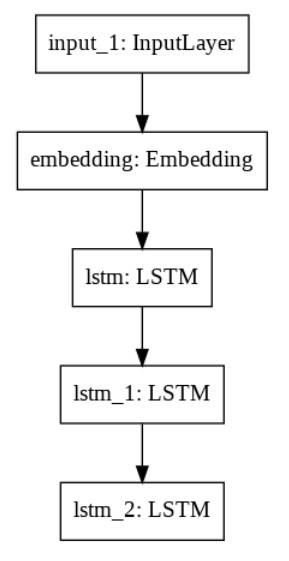




```
plot_model(gen_decoder)
```


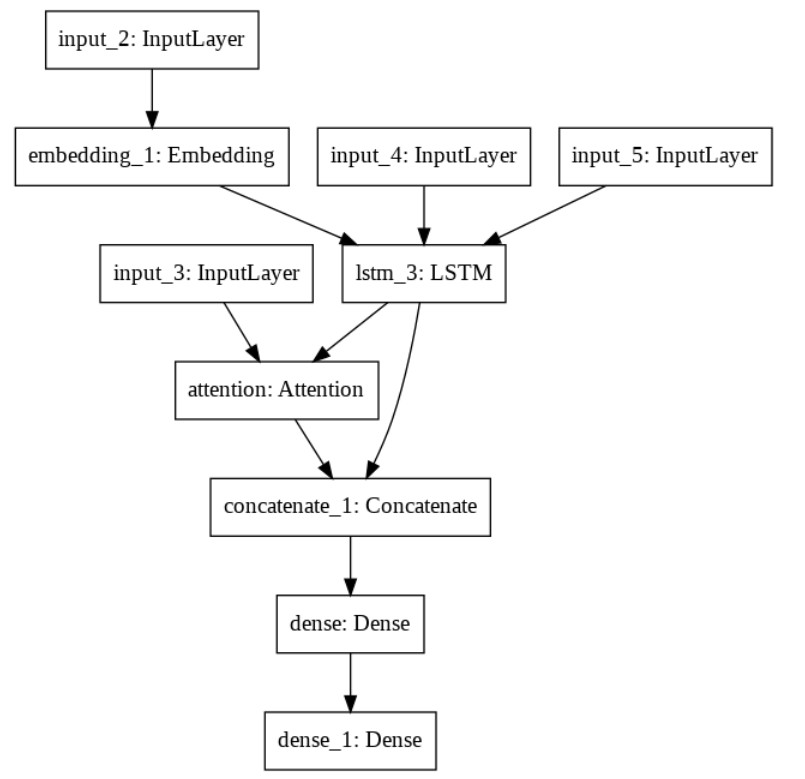

In [39]:
X_test_encode = np.array(pad_sequences(input_tokenizer.texts_to_sequences(X_test), maxlen=maxLength,padding="post"))
test_length = len(X_test_encode)

y_predict = []
predicted = model.predict(X_test_encode)
for predict in predicted:
    index2, value = max(enumerate(predict), key=operator.itemgetter(1))
    y_predict.append(classes[index2])
    
print(y_predict[:10])

['Enjoyment', 'Other', 'Fear', 'Fear', 'Other', 'Other', 'Disgust', 'Enjoyment', 'Other', 'Disgust']


## 3.Report the performance metrics (Accuracy, F1-score...)

In [40]:
precision = precision_score(y_test, y_predict, average='weighted')
recall = recall_score(y_test, y_predict, average='weighted')
f1score = f1_score(y_test, y_predict, average='micro')
accuracy = accuracy_score(y_test, y_predict)

print("Result model LSTM + Attention layer")
print("Results of the models")
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-Score: ", f1score)
print("Accuracy: ", accuracy)

print(classification_report(y_test,y_predict))

Result model LSTM + Attention layer
Results of the models
Precision:  0.5176079843450203
Recall:  0.5064935064935064
F1-Score:  0.5064935064935064
Accuracy:  0.5064935064935064
              precision    recall  f1-score   support

       Anger       0.31      0.38      0.34        40
     Disgust       0.46      0.47      0.47       132
   Enjoyment       0.63      0.58      0.60       193
        Fear       0.67      0.65      0.66        46
       Other       0.40      0.49      0.44       129
     Sadness       0.53      0.47      0.50       116
    Surprise       0.54      0.41      0.46        37

    accuracy                           0.51       693
   macro avg       0.50      0.49      0.49       693
weighted avg       0.52      0.51      0.51       693



# VII.Enter the demo program into 1 sentence

In [41]:
def sample_indices(str):
  demo_pre = clean_doc(str)
  X_demo_encode = np.array(pad_sequences(input_tokenizer.texts_to_sequences([demo_pre]), maxlen=maxLength,padding="post"))
  predicted = model.predict(X_demo_encode)
  index2, value = max(enumerate(predicted[0]), key=operator.itemgetter(1))
  print(str)
  print("Predict the results:", classes[index2])
  print("="*45)

## Results on train dataset

In [42]:
for i in X_train[:5]:
  sample_indices(i)

cho mình xin bài nhạc tên là gì với ạ
Predict the results: Other
cho đáng_đời con quỷ về nhà lôi con nhà mày ra mà đánh
Predict the results: Disgust
lo học đi yêu_đương lol gì hay lại thích học_sinh_học
Predict the results: Disgust
uớc gì sau_này về già vẫn có_thể như cụ này
Predict the results: Enjoyment
mỗi lần có video của con là cứ coi đi coi lại hoài cưng con quá
Predict the results: Enjoyment


## Results on sentence

In [43]:
sample_indices('Tôi buồn không biết vì sao tôi buồn chắc vì người ta vui.Người ta vui vì tôi buồn.Cười cho đời thêm màu mới')

Tôi buồn không biết vì sao tôi buồn chắc vì người ta vui.Người ta vui vì tôi buồn.Cười cho đời thêm màu mới
Predict the results: Sadness
